In [1]:
import openmc
import os
import numpy as np
import matplotlib.pyplot as plt
import urllib
import matplotlib.figure
import pandas as pd
njoy_exec = '/Users/ameliajo/NJOY_CLEAN/bin/njoy'
h1_url = 'https://t2.lanl.gov/nis/data/data/ENDFB-VII.1-neutron/H/1'


In [2]:
def writeMaterials(addSAB):
    h2o = openmc.Material(name='h2o')
    h2o.add_nuclide('H1',2)
    h2o.add_nuclide('O16',1)
    h2o.set_density('g/cm3',100.0)
    h2o.temperature = 400.0
    if addSAB:
        h2o.add_s_alpha_beta('c_H_in_H2O')

    air = openmc.Material(name='air')
    air.add_nuclide('O16',1)
    air.set_density('g/cm3',1e-10)

    materials = openmc.Materials([h2o,air])
    materials.export_to_xml()
    return h2o,air

In [3]:
def writeGeometry(h2o,air,smallWidth,largeWidth):

    small_box_region2 = openmc.rectangular_prism(width=smallWidth, height=smallWidth)
    large_box_region2 = openmc.rectangular_prism(width=largeWidth, height=largeWidth, boundary_type='vacuum')

    small_box = openmc.Cell(region=small_box_region2,fill=h2o)
    large_box = openmc.Cell(region=large_box_region2,fill=air)

    universe = openmc.Universe()
    # universe.add_cells([small_box])
    universe.add_cells([small_box,large_box])

    geometry = openmc.Geometry(universe)
    geometry.export_to_xml()
    # universe.plot(width=(1.1*largeWidth,1.1*largeWidth))    
    return small_box

In [4]:
def prepThermalScatteringData(names):
    for name in names:
        if name == 'No-Sab':
            continue
        if name == '400-No-Sab':
            continue
        
        if name == '600-True':
            directory = '600/True' 
            temperatures = [600.0]  
        elif name == '600-XS-interp-500-800':
            directory = '600/True'
            temperatures = [500.0,800.0]
        elif name == '600-XS-interp-550-650':
            directory = '600/True'
            temperatures = [550.0,650.0]
        elif name == '600-XS-interp-573-623':
            directory = '600/True'
            temperatures = [573.6,623.6]
        elif name == '400-True':
            directory = '400/True' 
            temperatures = [373.6,400.0,423.6]  
        elif name == '400-XS-interp-300-500':
            directory = '400/True'
            temperatures = [300.0,500.0]
        elif name == '400-XS-interp-350-450':
            directory = '400/True'
            temperatures = [350.0,450.0]
        elif name == '400-XS-interp-373-423':
            directory = '400/True'
            temperatures = [373.6,423.6]   
        elif name == '400-Wrong-Dos-800':
            directory = '400/wrongDOS_800'
            temperatures = [373.6,400.0,423.6]   

        else:
            print(name+' not found')
            return

        if not os.path.exists('h1.endf'):
            filename, headers = urllib.request.urlretrieve(h1_url,'h1.endf')
        if not os.path.exists('sab_h5_files/'+name+'.h5'):
            filename = './LEAPR_OUTPUT/'+directory+'/tape24'
            h_in_h2o = openmc.data.ThermalScattering.from_njoy(
                'h1.endf',filename,temperatures=temperatures, 
                stdout=True, njoy_exec=njoy_exec)
            h_in_h2o.export_to_hdf5('sab_h5_files/'+name+'.h5')
        else:
            print(name+' is already prepared!')


In [5]:
def writeSettings(batches,particles,energy,smallWidth,interpolation):
    initial_point = openmc.stats.Point((-smallWidth*0.49, 0, 0))
    angle         = openmc.stats.Monodirectional([1.0,0.0,0.0])
    energy        = openmc.stats.Discrete([1.0],[energy])
    source = openmc.Source(space=initial_point, angle=angle, energy=energy)
    settings = openmc.Settings()
    settings.source = source
    settings.inactive = 0
    settings.seed = 1
    settings.batches = batches
    if interpolation:
        settings.temperature = {'method':'interpolation'}
    settings.run_mode = 'fixed source'
    settings.particles = int(particles)
    settings.export_to_xml()

In [6]:
def writeTallies(small_box,smallWidth,largeWidth,numEFilter,numSpaceFilter):
    tallies_file = openmc.Tallies()
    
    mesh = openmc.RegularMesh(mesh_id=1)
    mesh.type = 'regular'
    mesh.dimension = [1, numSpaceFilter]
    mesh.lower_left  = [-largeWidth*0.5, -largeWidth*0.5]
    mesh.upper_right = [ largeWidth*0.5,  largeWidth*0.5]
    #mesh.lower_left  = [-smallWidth*0.5, -smallWidth*0.5]
    #mesh.upper_right = [ smallWidth*0.5,  smallWidth*0.5]
    mesh_filter = openmc.MeshSurfaceFilter(mesh)

    thermal_leak = openmc.Tally(name='thermal leakage')
    thermal_leak.filters = [mesh_filter, openmc.EnergyFilter(np.linspace(0.0,1.2,numEFilter))]
    thermal_leak.scores = ['current']
    tallies_file.append(thermal_leak)

    tallies_file.export_to_xml()

In [7]:
def removeEarlierFiles(batches):
    if os.path.exists('./statepoint.'+str(batches)+'.h5'):
        os.remove('./statepoint.'+str(batches)+'.h5')
    if os.path.exists('./summary.h5'):
        os.remove('./summary.h5')


In [8]:

batches = 10
particles = 1e3
# particles = 1e5
energy = 0.1
smallWidth = 1e-6
largeWidth = 1e-5
numEFilter = 16
numSpaceFilter = 16

In [9]:
runs = ['400 No Sab',
        '400 True',
        #'400 XS interp 373 423',
        #'400 XS interp 350 450',
        #'400 XS interp 300 500',
        '400 Wrong Dos 800',      # Use 800K phonon DOS for 400K
       ]

names = [string.replace(' ','-') for string in runs]
prepThermalScatteringData(names)


400-True is already prepared!
400-Wrong-Dos-800 is already prepared!


In [10]:
means = []
muBins = []
std_dev = []
leakDF_vec = []

for name in names:
    
    addSAB = True
    interpolation = False
    if name == 'No-Sab' or name == '400-No-Sab':
        addSAB = False
    else:
        !{'cp sab_h5_files/'+name+'.h5 /Users/ameliajo/endfb71_hdf5/c_H_in_H2O.h5'}
    if 'XS-interp' in name or '400' in name:
        interpolation = True
    print(name,interpolation)
    
    h2o,air = writeMaterials(addSAB)
    small_box = writeGeometry(h2o,air,smallWidth,largeWidth)
    writeSettings(batches,particles,energy,smallWidth,interpolation)
    writeTallies(small_box,smallWidth,largeWidth,numEFilter,numSpaceFilter)
    removeEarlierFiles(batches)

    openmc.run()
    
    sp = openmc.StatePoint('statepoint.'+str(batches)+'.h5')
    leakDF  = sp.get_tally(name='thermal leakage').get_pandas_dataframe()
    leakDF_vec.append(leakDF)

    runName = 'Filters__E'+str(numEFilter)+'_Space'+str(numSpaceFilter)

    pathName = 'b'+str(int(batches))+'_p'+('%.0e'%particles).replace('+0','')+'_'+name.replace('-','_')
    if not os.path.exists('Results/'+runName):
        !{'mkdir Results/'+runName}

    if not os.path.exists('Results/'+runName+'/'+pathName):
        !{'mkdir Results/'+runName+'/'+pathName}
        !{'cp ScatteringExperiment.ipynb *.xml statepoint.'+str(batches)+'.h5 Results/'+runName+'/'+pathName}


400-No-Sab True
                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####

//anaconda3/lib/python3.7/site-packages/openmc/mixin.py:71: IDWarning: Another MeshBase instance already exists with id=1.
  warn(msg, IDWarning)


                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

//anaconda3/lib/python3.7/site-packages/openmc/mixin.py:71: IDWarning: Another MeshBase instance already exists with id=1.
  warn(msg, IDWarning)


                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

In [11]:
def getArray(leakDF):
    leakOut = leakDF.loc[leakDF["mesh 1"]["surf"] == "x-max out"]

    firstEntry = leakOut.loc[leakOut["mesh 1"]["x"] == 1].loc[leakOut["mesh 1"]["y"] == 1]
    EVals   = list(firstEntry["energy low [eV]"]) + [list(firstEntry["energy high [eV]"])[-1]]
    eMidVec = [(EVals[i]+EVals[i+1])*0.5 for i in range(len(EVals)-1)]

    array = np.zeros((len(eMidVec),max(list(leakOut["mesh 1"]["y"]))))
    for i,eMid in enumerate(eMidVec):
        E_specific = leakOut.loc[leakOut["energy low [eV]"] < eMid]\
                            .loc[leakOut["energy high [eV]"] > eMid]
        if list(E_specific["energy low [eV]"])[0] <= 1.0 and \
           list(E_specific["energy high [eV]"])[0] >= 1.0: continue
        array[i] = E_specific["mean"]
    return array,eMidVec

In [12]:
def plotArray(array,vmax=None):
    fig, ax = plt.subplots(1,1,figsize=(8,8))
    if vmax:
        plt.imshow(array,cmap='hot',extent=[-1,1,-1,1],vmin=0,vmax=vmax)
    else:
        plt.imshow(array,cmap='hot',extent=[-1,1,-1,1])
    plt.ylabel('Energy [eV]')
    plt.xlabel('Space [normalized]')
    desiredEPoints = np.linspace(0.0,1.2,13)
    desiredEPoints_shifted = [2*val/max(desiredEPoints) - 1.0 for val in desiredEPoints]
    desiredEPoints = ['%.1f'%val for val in desiredEPoints]
    ax.set_yticks(desiredEPoints_shifted);
    ax.set_yticklabels(desiredEPoints[::-1]);
    

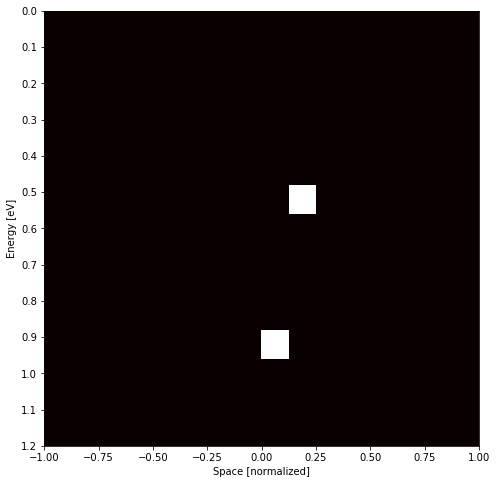

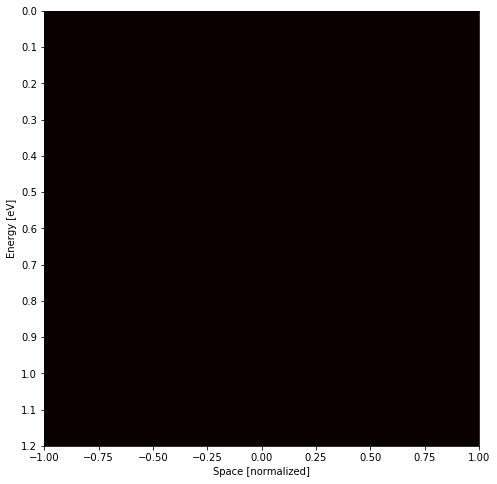

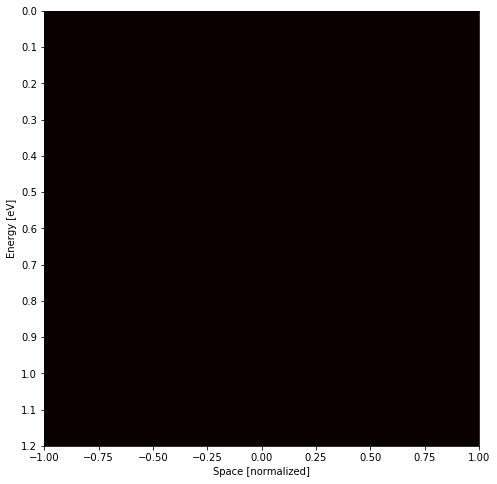

In [13]:
leakDF0  = leakDF_vec[0]
leakDF1  = leakDF_vec[1]
leakDF2  = leakDF_vec[2]

array0,Evals0 = getArray(leakDF0)
array1,Evals1 = getArray(leakDF1)
array2,Evals2 = getArray(leakDF2)

# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)
# pd.set_option('display.width', None)
plotArray(array0)
plotArray(array1)
plotArray(array2)



In [ ]:
leakDF0  = leakDF_vec[0]
leakDF1  = leakDF_vec[1]
leakDF2  = leakDF_vec[2]

array0,Evals0 = getArray(leakDF0)
array1,Evals1 = getArray(leakDF1)
array2,Evals2 = getArray(leakDF2)

error12 = np.divide(abs(array1-array2), array1, # This will only divide when
                    out=np.zeros_like(array1),  # value in array1 != 0
                    where=array1!=0)            # # This is giving rel. error
error01 = np.divide(abs(array0-array1), array0, # This will only divide when
                    out=np.zeros_like(array0),  # value in array1 != 0
                    where=array0!=0)            # # This is giving rel. error
error02 = np.divide(abs(array0-array2), array0, # This will only divide when
                    out=np.zeros_like(array1),  # value in array1 != 0
                    where=array0!=0)            # # This is giving rel. error
plotArray(error12)
plt.colorbar()



In [ ]:
integratedError = np.trapz(np.trapz(error12,x=np.linspace(0,largeWidth,numSpaceFilter)),x=Evals1)
print("Integrated Error is: ",integratedError)

In [ ]:
integratedError = np.trapz(np.trapz(error01,x=np.linspace(0,largeWidth,numSpaceFilter)),x=Evals1)
print("Integrated Error is: ",integratedError)

In [ ]:
integratedError = np.trapz(np.trapz(error02,x=np.linspace(0,largeWidth,numSpaceFilter)),x=Evals1)
print("Integrated Error is: ",integratedError)

In [ ]:
# plt.plot(muBinsMid,mean)

In [ ]:
# scatter = sp.get_tally(name='scatter (spatial)')
# df2 = scatter.get_pandas_dataframe()
# scatter.mean.shape = (100,100)
# plt.imshow(scatter.mean)

In [ ]:
import sys
sys.path.append('/Users/ameliajo/getPyENDFtk/ENDFtk/bin')
import ENDFtk

In [ ]:
files = ['400/True','400/wrongDOS_800']
# files = ['600/True','600/']
temperature = 400.0
for file in files:
    leaprTape = ENDFtk.tree.Tape.from_file('LEAPR_OUTPUT/'+file+'/tape24')
    inelastic = leaprTape.MAT(1).MF(7).MT(4).parse()
    scatteringLaw = inelastic.scattering_law

    for i in [0,10,50,100,200,300]:
        func = scatteringLaw.functions[i]
        alphas = func.alphas.to_list()
        beta = func.beta
        temperatures = func.temperatures.to_list()
        t = [j for j in range(len(temperatures)) if abs(temperatures[j] - temperature) < 1e-5][0]
        sab = func.thermal_scattering_values.to_list()
        plt.plot(alphas,sab[t])
plt.yscale('log')
plt.xlim([-50,500])

In [ ]:
files = ['400/True','400/wrongDOS_283','400/wrongDOS_800']
# files = ['400/True']#,'400/wrongDOS_800']
temperature = 400.0
Betas = []
info = []
for file in files:
    leaprTape = ENDFtk.tree.Tape.from_file('LEAPR_OUTPUT/'+file+'/tape24')
    inelastic = leaprTape.MAT(1).MF(7).MT(4).parse()
    scatteringLaw = inelastic.scattering_law
    SAB = np.zeros((scatteringLaw.number_betas,len(scatteringLaw.functions[0].alphas)))
    betas = []
    for i in range(len(scatteringLaw.functions)):
        func = scatteringLaw.functions[i]
        alphas = func.alphas.to_list()
        beta = func.beta
        betas.append(beta)
        temperatures = func.temperatures.to_list()
        t = [j for j in range(len(temperatures)) if abs(temperatures[j] - temperature) < 1e-5][0]
        sab = func.thermal_scattering_values.to_list()
        SAB[i] = sab[t]
    Betas.append(betas)
    SAB = np.transpose(SAB)
    info.append(SAB)


In [ ]:
plt.figure(figsize=(8,6))
for ibeta in [0]:
    plt.plot(Betas[0],info[0][ibeta])
for ibeta in [0]:
    plt.plot(Betas[1],info[1][ibeta],linestyle='--')
for ibeta in [0]:
    plt.plot(Betas[2],info[2][ibeta],linestyle='-.')
    
#plt.plot(alphas,sab[t])
plt.yscale('log')
# plt.xscale('log')
# plt.xlim([1,15])
# plt.xlim([-50,500])
plt.xlim([-3,20])
# plt.xlim([8,8.25])
# plt.xlim([-1,20])

In [ ]:
index = 80
for ibeta in [0,50]:
    plt.plot(Betas[0][:index],info[0][ibeta][:index])
for ibeta in [0,50]:
    plt.plot(Betas[1][:index],info[1][ibeta][:index],linestyle='--')
    
#plt.plot(alphas,sab[t])
plt.yscale('log')
# plt.xlim([-50,500])
plt.xlim([-10,60])
# plt.xlim([-1,20])

In [ ]:
file = '400/True'
Betas = []
info = []

leaprTape = ENDFtk.tree.Tape.from_file('LEAPR_OUTPUT/'+file+'/tape24')
inelastic = leaprTape.MAT(1).MF(7).MT(4).parse()
scatteringLaw = inelastic.scattering_law
temperatures = scatteringLaw.functions[0].temperatures.to_list()

for itemp in range(len(temperatures)):

    betas = []
    SAB = np.zeros((scatteringLaw.number_betas,len(scatteringLaw.functions[0].alphas)))

    for i in range(len(scatteringLaw.functions)):
        func = scatteringLaw.functions[i]
        alphas = func.alphas.to_list()
        beta = func.beta
        betas.append(beta)
        sab = func.thermal_scattering_values.to_list()
        SAB[i] = sab[itemp]
    Betas.append(betas)
    SAB = np.transpose(SAB)
    info.append(SAB)


In [ ]:
plt.plot(Betas[0],info[0][0])
plt.plot(Betas[0],info[4][0])
plt.plot(Betas[0],info[8][0])
plt.plot(Betas[0],info[17][0])
plt.yscale('log')
plt.xlim([-3,30])

In [ ]:
# currentOut = sp.get_tally(name='current')
# df = currentOut.get_pandas_dataframe()

# xMin = df.loc[df['mesh 2']['surf'] == 'x-min out' ]
# xMax = df.loc[df['mesh 2']['surf'] == 'x-max out' ]
# yMin = df.loc[df['mesh 2']['surf'] == 'y-min out' ]
# yMax = df.loc[df['mesh 2']['surf'] == 'y-max out' ]

# plt.plot(list(xMax["mean"]))

In [ ]:
Betas[0]

In [ ]:
# currentOut = sp.get_tally(name='current_leaving')
# df = currentOut.get_pandas_dataframe()

# xMin = df.loc[df['mesh 2']['surf'] == 'x-min out' ]
# xMax = df.loc[df['mesh 2']['surf'] == 'x-max out' ]
# yMin = df.loc[df['mesh 2']['surf'] == 'y-min out' ]
# yMax = df.loc[df['mesh 2']['surf'] == 'y-max out' ]

# plt.plot(list(xMax["mean"]))

In [ ]:

# # Instantiate a tally mesh
# mesh = openmc.RegularMesh(mesh_id=2)
# mesh.dimension = [100, 100]
# mesh.lower_left  = [-largeWidth*0.5, -largeWidth*0.5]
# mesh.upper_right = [ largeWidth*0.5,  largeWidth*0.5]
# # mesh.x_grid = [np.linspace(-largeWidth*0.5+0.5,largeWidth*0.5-0.5,10)]
# # mesh.y_grid = [np.linspace(-largeWidth*0.5+0.5,largeWidth*0.5-0.5,10)]


# meshsurface_filter = openmc.MeshSurfaceFilter(mesh)


# # Instantiate thermal, fast, and total leakage tallies
# leak = openmc.Tally(name='current_leaving')
# leak.filters = [meshsurface_filter]
# leak.scores = ['current']
# tallies_file.append(leak)